# Robot de Almacén

### Datos a considerar
- La semilla para generación de números aleatorios será 67890.
- El almacén es 20x20 celdas.
- Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
- Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
- La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.


### Resultados
-	Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
-	Una visualización que permita ver los diferentes pasos de la simulación.
-	El número de pasos necesarios para terminar la simulación.
-	¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?


### Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [104]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd
import random

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [105]:
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.id = id

    def step(self):
        possible_cells = self.model.grid.get_neighborhood(self.pos, moore=False, include_center = False)
        cellmate = False
        while(cellmate == False):
            new_position = self.random.choice(possible_cells)
            cellmate = self.model.grid.get_cell_list_contents([new_position])

        self.model.grid.move_agent(self, new_position)
        self.pos = new_position

In [106]:
def get_robots(model):
    return np.asarray([agent.pos for agent in model.schedule.agents])

In [107]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_agents):
          self.schedule = SimultaneousActivation(self)
          self.grid = MultiGrid(width, height, torus = False)
          self.datacollector = DataCollector(model_reporters={"Robot": get_robots})

          for i in range(num_agents):
              x = random.randrange(self.grid.width)
              y = random.randrange(self.grid.height)
              agent = RobotAgent(i, self)
              self.schedule.add(agent)
              self.grid.place_agent(agent, (x,y))

    def step(self):
         self.datacollector.collect(self)
         self.schedule.step()

In [108]:
WIDTH = 20
HEIGHT = 20
ROBOTS = 5
ITERATIONS = 100
SEED = 67890
random.seed(SEED)

In [109]:
model = WarehouseModel(WIDTH, HEIGHT, ROBOTS)
for i in range(ITERATIONS):
    model.step()

In [110]:
all_positions = model.datacollector.get_model_vars_dataframe()

C:\Users\sgarn\AppData\Local\Temp\ipykernel_15620\2148707644.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
C:\Users\sgarn\AppData\Local\Temp\ipykernel_15620\2148707644.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])


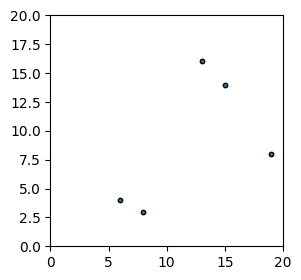

In [111]:
fig, ax = plt.subplots(figsize=(3, 3))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
ax.axis([0, WIDTH, 0, HEIGHT])

def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])
    return scatter

anim = animation.FuncAnimation(fig, animate, frames = ITERATIONS)

In [112]:
anim

C:\Users\sgarn\AppData\Local\Temp\ipykernel_15620\2148707644.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])
